In [33]:
import os
import sys

import numpy as np
from river.decomposition import OnlineDMD, OnlineSVD
from river.preprocessing import Hankelizer
from tqdm import tqdm

sys.path.append("../")
from functions.chdsubid import SubIDChangeDetector
from functions.datasets import load_nprs43, load_nprs44
from functions.plot import plot_chd
from functions.rolling import Rolling

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Snapshots processed: 100%|██████████| 6500/6500 [00:38<00:00, 169.61it/s]


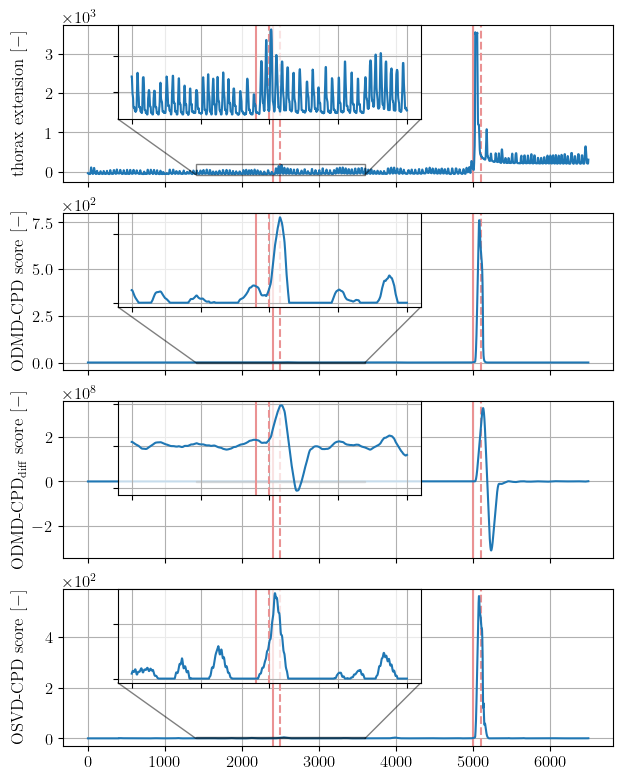

In [36]:
# [donotremove]
# Read data
X = load_nprs44()[15500:22000]

# Initialize Parameters
# Kawahara 2007 parameters
window_size = 300
hn = 80
ref_size = 100
test_size = 100
r = 2

# Initialize Hankelizer
hankelizer = Hankelizer(hn)

# Initialize Transformer
init_size = window_size
odmd = Rolling(
    OnlineDMD(
        r=r,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-1,
    ),
    init_size + 1,
)
# Ref
osvd = OnlineSVD(r, initialize=init_size, force_orth=False)
# Initialize Change-Point Detector
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
# Ref
subid_svd = SubIDChangeDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn, r), dtype=complex)
mean_modes = np.empty(X.shape[0], dtype=complex)
svs = np.zeros((X.shape[0], r, r), dtype=float)
us = np.zeros((X.shape[0], hn, r), dtype=float)
As = np.zeros((X.shape[0], r, r), dtype=float)

# Run pipeline
for i, (x) in tqdm(
    enumerate(X),
    total=len(X),
    mininterval=1.0,
    desc="Snapshots processed",
):
    scores_dmd[i] = pipeline_dmd.score_one({"x": x})
    scores_svd[i] = pipeline_svd.score_one({"x": x})
    dist[i, :] = subid_dmd.distances
    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

    pipeline_dmd.learn_one({"x": x})
    pipeline_svd.learn_one({"x": x})

    if subid_dmd.n_seen > window_size + test_size:
        modes[i, :, :] = odmd.modes
        mean_modes[i] = modes[i, :, :].mean()
        svs[i, :, :] = odmd._svd._S
        us[i, :, :] = odmd._svd._U
        As[i, :, :] = odmd.A

# Plot results
fig, axs = plot_chd(
    {
        "thorax extension $[-]$": X,
        "ODMD-CPD score [$-$]": scores_dmd.real,
        "ODMD-CPD$_\\mathrm{diff}$ score [$-$]": scores_dmd_diff.real,
        "OSVD-CPD score [$-$]": scores_svd.real,
    },
    [2400, 5000],
    grace_period=test_size,
    ids_in_start=[1500],  # Original 16190
    ids_in_end=[3500],  # Original 16344
)

fig_name = (
    f"results/.nprs/nprs44-chd_r{r}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-h{hn}.pdf"
)
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)

Snapshots processed: 100%|██████████| 4000/4000 [00:19<00:00, 201.11it/s]


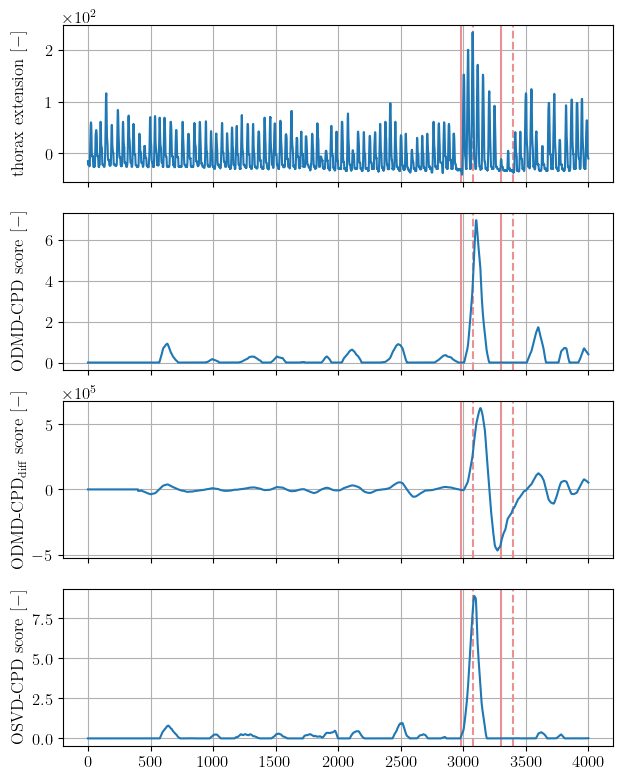

In [37]:
# [donotremove]
# Read data
X = load_nprs43()[10000:14000]

# Initialize Parameters
# Kawahara 2007 parameters
window_size = 300
hn = 80
ref_size = 100
test_size = 100
r = 2

# Initialize Hankelizer
hankelizer = Hankelizer(hn)

# Initialize Transformer
init_size = window_size
odmd = Rolling(
    OnlineDMD(
        r=r,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-1,
    ),
    init_size + 1,
)
# Ref
osvd = OnlineSVD(r, initialize=init_size, force_orth=False)
# Initialize Change-Point Detector
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
# Ref
subid_svd = SubIDChangeDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn, r), dtype=complex)
mean_modes = np.empty(X.shape[0], dtype=complex)
svs = np.zeros((X.shape[0], r, r), dtype=float)
us = np.zeros((X.shape[0], hn, r), dtype=float)
As = np.zeros((X.shape[0], r, r), dtype=float)

# Run pipeline
for i, (x) in tqdm(
    enumerate(X),
    total=len(X),
    mininterval=1.0,
    desc="Snapshots processed",
):
    scores_dmd[i] = pipeline_dmd.score_one({"x": x})
    scores_svd[i] = pipeline_svd.score_one({"x": x})
    dist[i, :] = subid_dmd.distances
    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

    pipeline_dmd.learn_one({"x": x})
    pipeline_svd.learn_one({"x": x})

    if subid_dmd.n_seen > window_size + test_size:
        modes[i, :, :] = odmd.modes
        mean_modes[i] = modes[i, :, :].mean()
        svs[i, :, :] = odmd._svd._S
        us[i, :, :] = odmd._svd._U
        As[i, :, :] = odmd.A

# Plot results
fig, axs = plot_chd(
    {
        "thorax extension $[-]$": X,
        "ODMD-CPD score [$-$]": scores_dmd.real,
        "ODMD-CPD$_\\mathrm{diff}$ score [$-$]": scores_dmd_diff.real,
        "OSVD-CPD score [$-$]": scores_svd.real,
    },
    [2980, 3300],
    grace_period=test_size,
)

fig_name = (
    f"results/.nprs/nprs43-chd_r{r}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-h{hn}.pdf"
)
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)